# INF200 Lecture No. Ju04

### Hans Ekkehard Plesser
### 08 June 2023

## Today's topics

- A bit more on testing
- Packaging
    - Packaging your code for distribution
    - Choosing version numbers
    - Running tests with Tox and running tests on GitLab
- Code design: Structure and flow of information

----------------------

# A bit more on testing

## Test classes with setup and teardown fixtures

- We can combine tests that are related into a class
- The class name must begin with `Test`
- Each method with a name beginning with `test_` will be run as a test
- Methods with other names can be used as helpers
- Most important helpers: setup and teardown fixtures
    - http://pytest.readthedocs.io/en/latest/fixture.html#fixture
- How it works
    - Create method that does preparation for tests or cleanup after tests
    - Mark method as PyTest fixture with `@pytest.fixture` decorator
    - Fixtures with `autouse=True` will be applied to every test in the class
    - Other fixtures will only be used if passed to a test method
    - Code before `yield` is run before the test (setup)
    - Code after `yield` is run after the test (teardown), independent of whether the test fails or not
    - If there is no `yield`, the method only performs setup
- See `june_block/examples/biolab_project` for examples
- Note: fixtures can also be defined at the module level, but then it is difficult to share objects created during setup with the tests
- **NB: Do not overuse fixtures!**

```python
class TestDeathDivision:
    
    @pytest.fixture(autouse=True)
    def create_dish(self):
        self.n_a = 10
        self.n_b = 20
        self.dish = Dish(self.n_a, self.n_b)

    @pytest.fixture
    def reset_bacteria_defaults(self):
        # no setup
        yield

        # reset class parameters to default values after each test
        Bacteria.set_params(Bacteria.default_params)

    def test_death(self):
        n_a_old = self.dish.get_num_a()
        n_b_old = self.dish.get_num_b()

        for _ in range(10):
            self.dish.death()
            n_a = self.dish.get_num_a()
            n_b = self.dish.get_num_b()
            # n_a and n_b must never increase
            assert n_a <= n_a_old and n_b <= n_b_old
            n_a_old, n_b_old = n_a, n_b

    def test_division(self):
        n_a_old = self.dish.get_num_a()
        n_b_old = self.dish.get_num_b()

        for _ in range(10):
            self.dish.division()
            n_a = self.dish.get_num_a()
            n_b = self.dish.get_num_b()
            # n_a and n_b must never decrease
            assert n_a >= n_a_old and n_b >= n_b_old
            n_a_old, n_b_old = n_a, n_b

    def test_all_die(self, reset_bacteria_defaults):
        Bacteria.set_params({'p_death': 1.0})
        self.dish.death()
        assert self.dish.get_num_a() == 0 and self.dish.get_num_b() == 0

    @pytest.mark.parametrize("n_a, n_b, p_death",
                             [[100, 200, 0.1],
                              [100, 200, 0.9],
                              [10, 20, 0.5]])
    def test_death(self, reset_bacteria_defaults, n_a, n_b, p_death):

        Bacteria.set_params({'p_death': p_death})
        dish = Dish(n_a, n_b)
        dish.death()
        died_a = n_a - dish.get_num_a()
        died_b = n_b - dish.get_num_b()

        pass_a = binom_test(died_a, n_a, p_death) > ALPHA
        pass_b = binom_test(died_b, n_b, p_death) > ALPHA
        
        assert pass_a and pass_b
```

## Mocking

- Temporarily replace a Python object with a different one, typically replacing a class or method
- Supported by Python `unittest.mock`
    - Relatively complex
    - We will not use it directly
    - For documentation, see
        - https://docs.python.org/3/library/unittest.mock-examples.html
        - https://docs.python.org/3/library/unittest.mock.html#the-mock-class
- For convenient mocking with py.test, we need a py.test extension `pytest-mock`
    - For documentation, see https://pytest-mock.readthedocs.io/en/latest/
- Mocking is most useful for "glass box" testing, since we need to know which functions to mock.
    - Useful if functions are not available yet but we want to test code calling them
- **Use sparingly**, focus on tests on *what* methods do, not *how* they do it

### Example: Replacing random generator with fixed value

- See also `chutes_project/tests/test_player.py`
- In the test below, `random.randint` is replaced by a function that always returns `1`. The modification is in force only in that test.

```python
def test_single_step_one(mocker):
    mocker.patch('random.randint', return_value=1)
    b = Board(chutes=[], ladders=[])
    pl = Player(b)
    pl.move()
    assert pl.position == 1
```

- `mocker` is automatically provided by py.test if the `pytest-mock` extension is installed, no imports required

### Example: Counting the number of calls to a method

- See `examples/biolab_project/biolab/tests/test_dish.py`

```python
    def test_dish_aging_calls(self, mocker):
        mocker.spy(Bacteria, 'ages')

        n_a, n_b = 10, 20
        d = Dish(n_a, n_b)
        d.aging()

        assert Bacteria.ages.call_count == n_a + n_b
```

- `mocker.spy()` wraps `Bacteria.ages` so we can extract information later
- `Bacteria.ages.call_count` gives the number of times `Bacteria.ages` has been called
- The "spy" has an effect only inside this test

## Tests involving randomness

- Test methods that depend on random numbers
- Exact results will depend on precise sequence of random numbers generated, i.e., on the random generator used and the random seed

### Brute-force approaches

#### Fixed seed
By seeding the random number generator with a fixed value, we can ensure that we always get the same sequence of random numbers; particularly important while debugging.

- Requires that we know which random number generator is used by methods tested
- Adding more tests or changing tests or code can change the way in which random numbers are consumed

#### Mocking
Mock the random number function to return a fixed value.

- Allows us to check that the code using the random numbers works as expected
- Does not test whether the result has the expected distribution
- Requires that we know exactly how the code draws random numbers (glass box testing (aka white box testing))

### Statistical tests

- The principal approach is based on statistical testing of hypothesis
    - Formulate a hypothesis (expectation), e.g., "value $x$ is a sample of random variable $X$ which has a normal (Gaussian) distribution of given mean $\mu$ and variance $\sigma$"
    - Find the $p$-value of $x$, i.e., the probability to observe a value at least as far from the mean as $x$ if $x$ indeed follows the assumed distribution
    - Compare the $p$-value to a predefined acceptance limit $\alpha$: if $p>\alpha$ the test is passed
- Interpretation: Let, e.g., $\alpha=0.01=1\%$. If we observe a value $x$ with a $p$-value less than $\alpha=1\%$, this means that the value $x$ belongs to the outer tail of the assumed distribution, among those values that make up the 1% least likely values in the distribution. We thus assume that $x$ did not come from the expected distribution and declare the test failed.
- Note: By construction, this test will fail in 1% of all cases even if $x$ follows the assumed distribution. Thus, failures need to be inspected carefully.
- See, e.g., Knuth, The Art of Computer Programming, vol 2.

#### Examples of statistical tests

- [$Z$-test](https://en.wikipedia.org/wiki/Z-test)
    - Strictly speaking, tests whether the mean of $n$ random values drawn independently from the same distribution is from a Gaussian distribution of given mean and variance 
    - Due to the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem), it can also be applied in many other cases as an approximation provided we are considering averages of many trials
    - If the variance of the Gaussian distribution is not know a priori, one should use [Student's $t$-test](https://en.wikipedia.org/wiki/Student%27s_t-test) instead

- [Binomial test](https://en.wikipedia.org/wiki/Binomial_test)
    - An explicit test for [binomially distributed quantities](https://en.wikipedia.org/wiki/Binomial_distribution), e.g., the number of successes in $n$ Bernoulli experiments (coin flips)
    - See also [GraphPad](https://www.graphpad.com/guides/prism/latest/statistics/stat_binomial.htm) for an explanation of the test. 
    - SciPy has an [older](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom_test.html#scipy.stats.binom_test) and a [newer](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binomtest.html#scipy.stats.binomtest) implementation of the binomial test available
        - The older variant is *deprecated* and be removed in a future version of SciPy
        - Use the newer version in new code
        - The difference is in details of arguments needed and how the result is returned
        - We will see in the BioLab example how to convert from old to new
- `scipy.stats` provides [a number of statistical test functions](https://docs.scipy.org/doc/scipy/reference/stats.html#statistical-tests)

----------------

# Packaging your code for distribution

Let us say you have spent the last year creating some really great Python code, and now you want to share it with others. What do we need to do?
- Need to put "everything together" into a nice "parcel"
- Need to handle *dependencies* (e.g., that our code needs NumPy)
- Need to "spread the word (code)"

**Python solution**: *Packaging*

## Packages *vs* Packages

You might have noted that we now have to different things called *packages*, they are either
- Collections of modules (*import packages*)
- A collection of code neatly packaged for sharing with others (*distribution packages*)

Yes, having the same name for two different things is confusing. Programmers are horrible at naming conventions, we just have to deal with that

The [Python Packaging User Guide Glossary](https://packaging.python.org/glossary/) defines a Distribution Package as

    "A versioned archive file that contains Python packages, modules, and other resource files that are used to distribute a Release. The archive file is what an end-user will download from the internet and install."

### Where to share distribution packages?

You have now created a nice distribution package of your code (we will check out the details soon), how do you share it? 
- If it is only with a few people, email, direct transfer, etc is fine
- If you want to keep the code open for everyone to see, github/bitbucket is a nice way to do it
- Alternatively, you can use the [Python Package Index (PyPI)](https://pypi.python.org), aka the "CheeseShop"
- If you want to make it easily available for Conda users, consider creating a [Conda package as well](https://docs.conda.io/projects/conda-build/en/latest/user-guide/tutorials/build-pkgs.html)
    - [Discussion of Conda vs PIP by Jake Vanderplas (from 2016)](https://jakevdp.github.io/blog/2016/08/25/conda-myths-and-misconceptions/)

### Python packaging: a convoluted history

- Creating distribution packages for Python has a long and difficult history
- Pure Python packages reasonably simple, but packages depending, e.g., on optimized numerics libraries such as NumPy were difficult
- Various approaches over time, e.g., setuptools, distutil, eggs, wheels, ...
    - also external package managers such as conda
- Relatively recent standardization
    - [PEP 517 — A build-system independent format for source trees](https://www.python.org/dev/peps/pep-0517/)
    - [PEP 518 — Specifying Minimum Build System Requirements for Python Projects](https://www.python.org/dev/peps/pep-0518/)
- Still a lot of outdated or partially up-to-date information out there

## How do we prepare our code for distribution?

We cover only the basics here. 

- Description in the following built on
    - https://packaging.python.org/tutorials/packaging-projects/
    - https://docs.python.org/3/distributing/index.html
    - https://setuptools.readthedocs.io/en/latest/userguide/quickstart.html
    - https://setuptools.readthedocs.io/en/latest/userguide/declarative_config.html
- For more information, see also
    - https://packaging.python.org/guides/distributing-packages-using-setuptools/
    - https://packaging.python.org/guides/
- Or this guide by Yngve Moe, one of the INF200 examiners
    - https://github.com/yngvem/python-project-structure/
- **NB:** The documents above may suggest slightly different approaches to packaging. They are provided to give you more background information. If in doubt, stick to the setup provided in the project template and the `biolab` example. Contact Plesser if you want to discuss approaches.

#### Key idea of a distribution package

We want to make sharing Python-based projects easy
- Collect
    - Source code: Python modules, import packages, tests
    - Example scripts
    - Documentation
    - ...
    
    
- Provide *metadata* about the code, e.g.,
    - Purpose, Dependencies, Author information
    - License information, Version information, ...
    
    
- Provide a *build archive*
- Support easy installation to predefined locations

#### Example: Typical distribution package directory layout

```
biolab_project/
   docs/
   examples/
      experiment_01.py
      ...
   src/
       biolab/
          __init__.py
          bacteria.py
          ...
   tests/
       test_bacteria.py
       ...
   .gitlab-ci.yml
   LICENSE
   pyproject.toml
   README.md
   setup.cfg
   setup.py
   tox.ini
```

In our example, `biolab` is an import package included in our distribution, it is the source code. In this example `tests` is placed next to the source code package.

In addition to the `biolab` package we have a folder called `examples`, with some scripts the user can look at to see how the `biolab` package can be used. Note that `examples` is *not* a package, as it does not have an `__init__.py` file, it is just a regular folder. If you have a Jupyter notebook with examples, it could also be placed here. `docs` contains documentation, see below.

#### Configuration files

- `LICENSE` includes the license for your code.
    - Choose your license carefully!
    - Do not try to write your own license (unless you are a lawyer, maybe ...).
    - Three major categories of open source licenses
        - Viral licenses, e.g., GNU Public License (GPL)
        - Permissive licenses, e.g., BSD or MIT licenses
        - Other licenses
    - See also
        - https://opensource.org/licenses
        - https://choosealicense.com
- A `README.md` contains a description of the distribution package, and usually contain some information to the user about how to install it and where to look for examples/documentation. The file type is flexible, but [Markdown](https://en.wikipedia.org/wiki/Markdown) is common
- `pyproject.toml` describes the build system for creating your package. It should usually be just

    ```
    
    [build-system]
    requires = ["setuptools", "wheel"]
    build-backend = "setuptools.build_meta"
    
    
    ```
    
- `setup.cfg` is the main configuration file describing our package, discussed in more detail below. It is a *declarative* (*static*) configuration file. This is the preferred modern way of providing the configuration information. For details, see comments in `biolab_project/setup.cfg` and links above.
- `setup.py` is an *imperative* (*dynamic*) file used in the past to provide information about package configuration. It can fill the same role as `setup.cfg` and was widely used in the past. If you have a `setup.cfg` file, then `setup.py` can be omitted or should only contain

    ```python
    import setuptools
    setuptools.setup()

    ```

- `tox.ini` and `.gitlab-ci.yml` configure testing and will be discussed below.

## Building a distribution package

- Open a terminal or Anaconda prompt, or open a Terminal in PyCharm
- Go to the top-level directory for your project, here `biolab_project`
- Make sure you have the correct conda environment activated
- Run
```
python -m build
```
- Python `setuptools` will do all the work
    - Files created in this process are placed in directory `build` 
        - may be automatically deleted at end of build process
    - The files you can distribute will be placed in `dist`
- In our case we get in `dist` (on Windows, we get `zip` archive instead of `tar.gz`)
    - `biolab-0.1-tar.gz` (plain archive with source files)
    - `biolab-0.1-py3-none-any.whl` (Python Wheel)
- Wheels are current standard Python package distribution archives
    - can handle depdencies on C libraries
    - `none-any` will be replaced with system-specific names if building with C libraries
    - For more, see https://realpython.com/python-wheels/
- Material in `build` or `dist` could confuse PyCharm code inspection, so set `Mark directory as > Excluded` for those directories.
- **Do not commit** the `build` and `dist` directories!
- You could now upload your package to PyPi using `twine`, but we will skip that part in this course.

## Installing a package 

### "Manually" from a plain archive

This is the old-fashioned (pre-wheel) way of doing it.

1. Unpack the `tar.gz` or `zip` file
1. Move into the directory that we unpacked
1. Run
   ```
   python setup.py install
   ```

- This will install in the default location for packages in your current Python environment.
- Packages installed like this **cannot** be uninstalled easily.

### Installing the `pip` way

- The smart and modern way of doing it
- If package is available on PyPi, just
  ```
  pip install xyz
  ```
- To install from a local file
  ```
  pip install biolab-0.1-py3-none-any.whl
  ```
- Also installs to default location
- Package can be uninstalled with `pip uninstall biolab`

## Choosing version numbers

- [Semantic Versioning](https://semver.org) is a widely used approach

### Semantic versioning principles

The following are key principles of semantic versioning from semver.org. See that page for details.

1. Software using Semantic Versioning MUST declare a public API ... it SHOULD be precise and comprehensive.
1. A normal version number MUST take the form X.Y.Z where ... X is the major version, Y is the minor version, and Z is the patch version. Each element MUST increase numerically.
1. Once a versioned package has been released, the contents of that version MUST NOT be modified. Any modifications MUST be released as a new version.
1. Major version zero (0.y.z) is for initial development. Anything MAY change at any time. The public API SHOULD NOT be considered stable.
1. Version 1.0.0 defines the public API. The way in which the version number is incremented after this release is dependent on this public API and how it changes.
1. **Patch version Z** (x.y.Z | x > 0) MUST be incremented if only backwards compatible bug fixes are introduced. A bug fix is defined as an internal change that fixes incorrect behavior.
1. **Minor version Y** (x.Y.z | x > 0) MUST be incremented if new, backwards compatible functionality is introduced to the public API. It MUST be incremented if any public API functionality is marked as deprecated. It MAY be incremented if substantial new functionality or improvements are introduced within the private code. It MAY include patch level changes. Patch version MUST be reset to 0 when minor version is incremented.
1. **Major version X** (X.y.z | X > 0) MUST be incremented if any backwards *incompatible* changes are introduced to the public API. It MAY also include minor and patch level changes. Patch and minor versions MUST be reset to 0 when major version is incremented.

----------------

## Running tests with Tox and running tests on GitLab

### Tox

- [Tox](https://tox.readthedocs.io/en/latest/index.html) manages environments for controlled running of tests
- Sets up environment according to `setup.cfg` and `tox.ini` specifications and tests in this well-defined enviroment
- Configured by `tox.ini`, see `biolab_project/tox.ini` for example
- Run in terminal as
```
tox
```
- Places all its files in `.tox` directory, delete this if changes you make to Tox configuration seem to have no effect
- Mark `.tox` directory as `Excluded` in PyCharm
- **Do not commit** the `.tox` directory!

### GitLab test runners

- GitLab (and Github, Travis, Jenkins, ...) can tests automatically for us
- Test on every push to repository
- Good practice, also known as [Continuous Integration Testing (CI)](https://en.wikipedia.org/wiki/Continuous_integration)
- Can be extended to [Continuous Delivery/Deployment (CD)](https://en.wikipedia.org/wiki/Continuous_delivery)
- Requires `.gitlab-ci.yml` file at *top level* of repository
- See `biolab_project/.gitlab-ci.yml` for an example

#### Adding testing with `tox` to BioSim

- The `.gitlab-ci.yml` file in the project template only configures PEP8/flake8 testing of code
- To add running test with `tox` and `pytest`, add the following to the end of `.gitlab-ci.yml`:

```
test-tox:
  stage: test
  script:
    - tox
  artifacts:
    when: always
    paths:
      - pytest_results.xml
    reports:
      junit: pytest_results.xml
```

- The `script` section will run `tox` as you would from the command line
- The `artifacts` section tells GitLab to collect test results provided by `pytest` in file `pytest_results.xml` and make them available on the GitLab pages
    - For this to work, in `tox.ini`, pytest must be invoked with the `--junitxml` option
    
      ```
      commands =
          pytest --cov=biolab --randomly-seed=12345 --junitxml=pytest_results.xml tests
      ```
      
   - The command above will run only your tests in the `tests` directory. To also run the reference tests, change this line to
   
      ```
      commands =
          pytest --cov=biosim --randomly-seed=12345 --junitxml=pytest_results.xml tests reference_tests
      ```
      
#### Note
If GitLab asks for credit card information to check you identity, remove the `.gitlab-ci.yml` file. You cannot use automated testing in this case—but run the tests regularly on your computer!

### Running the GitLab tests on your own computer

1. Open `Terminal` in PyCharm or open a Terminal/Anaconda Prompt window
1. Make sure you
    - are in the `biosim-axx-name1-name2` directory
    - have activated the right conda environment
1. Run the formatting checks (`test-code-style` on GitLab) with
```
flake8 src tests examples
```
4. Run the tests on the code (`test-tox`) with
   ```
   tox
   ```
   If you have made changes to `tox.ini`, `pyproject.toml`, `setup.cfg` or `setup.py`, run
   ```
   tox --recreate
   ```
   or delete the `.tox` directory before running `tox`.

---

# Code design: Structure and flow of information

Discussion in class.

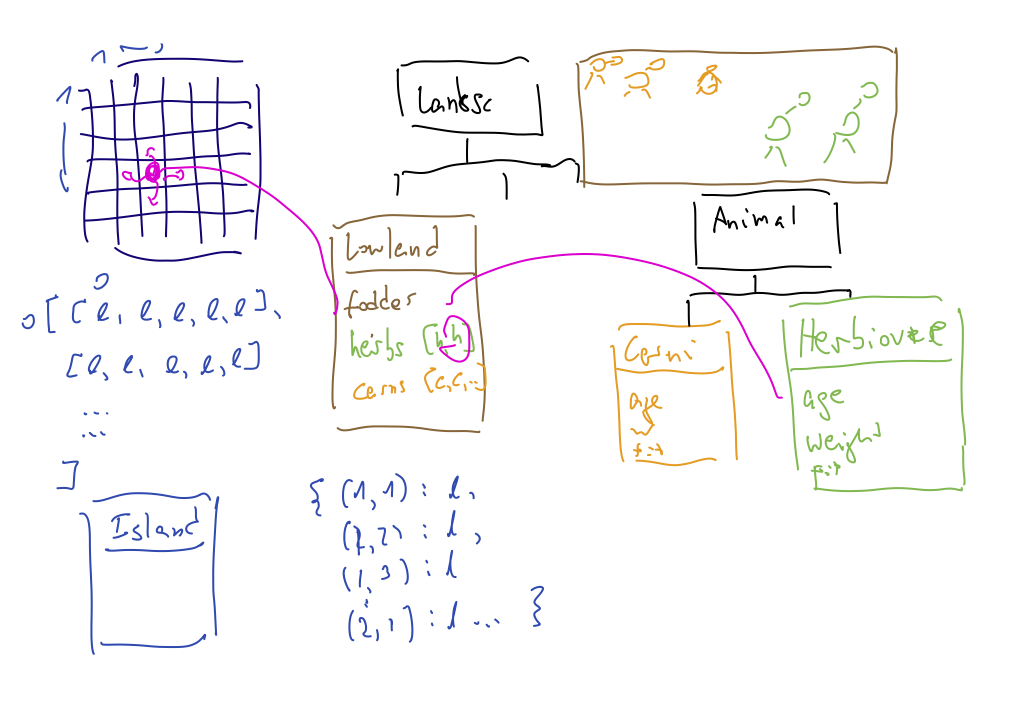